# a Classical Data assimilation on a HBV model using a Particle Filter

In [1]:
import warnings, glob
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from tqdm import tqdm

In [2]:
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Download plugin model

Ensure the HBV model is loaded and the Data Assimilation model is present:

```py
 pip install ewatercycle-HBV
 pip install ewatercycle-DA
```

This notebook uses the local HBV model
```py
pip install HBV 
```
If instead you want to use the docker model, use:
```py
from ewatercycle.models import HBV
```
and replace `HBVLocal` with `HBV`

#### set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
camels_path= path / "Camels"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
for path in [forcing_path, observations_path, figure_path, output_path, camels_path]:
    path.mkdir(exist_ok=True)

In [4]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-09-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [5]:
from ewatercycle.forcing import sources

This forcing file is availible at [https://github.com/Daafip/Msc-Thesis-Notebooks](https://github.com/Daafip/Msc-Thesis-Notebooks/tree/main/Forcing)

In [6]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

#### import model

In [7]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [8]:
truth_model = HBVLocal(forcing=camels_forcing)

In [9]:
truth_parameters = np.array([3.2,   0.9,  700,    1.2,   .16,   4,     .08,  .0075, 0.5])
truth_initial_storage = np.array([20,  10,  50,  100, 10])

In [10]:
config_file, _ = truth_model.setup(
            parameters=','.join([str(p) for p in truth_parameters]),
            initial_storage=','.join([str(s) for s in truth_initial_storage]),
           )

In [11]:
truth_model.initialize(config_file)

In [12]:
Q_m = []
time = []
while truth_model.time < truth_model.end_time:
    truth_model.update()
    Q_m.append(truth_model.get_value("Q"))
    time.append(truth_model.time_as_datetime.date())
truth_model.finalize()

In [13]:
truth = pd.DataFrame(Q_m, columns=["Q_m"],index=time)

In [14]:
rng = np.random.default_rng()  # Initiate a Random Number Generator
def add_normal_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state"""
    return rng.normal(loc=0, scale=like_sigma)

In [15]:
truth['Q'] = truth.apply(lambda x: x.Q_m + add_normal_noise(0.05) , axis=1)
truth.index = truth.apply(lambda x: pd.Timestamp(x.name),axis=1)
truth.index.name = "time"

<Axes: xlabel='time'>

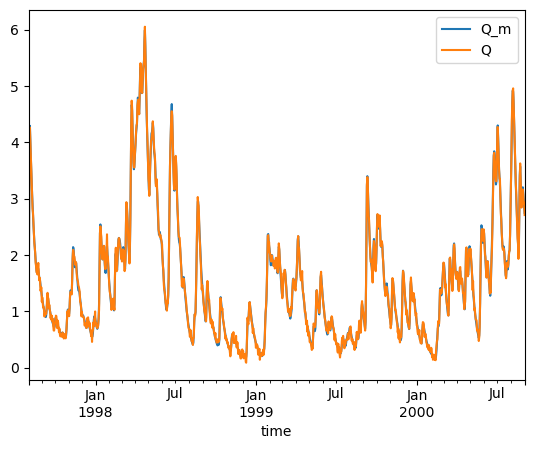

In [16]:
truth.plot()

In [17]:
ds_obs = xr.Dataset(data_vars=truth[['Q']])

In [18]:
current_time = str(datetime.now())[:-10].replace(":","_")
ds_obs_dir = observations_path / f'truth_model_HBV_{current_time}.nc'
if not ds_obs_dir.is_file():
    ds_obs.to_netcdf(ds_obs_dir)

#### import DA function:

In [19]:
from ewatercycle_DA import DA

In [20]:
n_particles = 150

In [21]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [22]:
# ## Array of initial storage terms - we keep these constant for now 
# ##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])
## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]
par_0 = (p_min_initial + p_max_initial)/2 # # set initial as mean of max,min

In [23]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [24]:
# values which you set
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [25]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [26]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[camels_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

## setup DA

This sets up all the require data assimilation information

In [27]:
lst_like_sigma = [0.005] * 14 + [0]
hyper_parameters = {'like_sigma_weights' : 0.05,
                    'like_sigma_state_vector' : lst_like_sigma,
                    'f_n_particles': 1}

In [28]:
def H(Z):
    if len(Z) == 15:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be 13 but is {len(Z)}")

In [29]:
ensemble.initialize_da_method(ensemble_method_name = "PF", 
                              hyper_parameters=hyper_parameters,                           
                              state_vector_variables = "all", # the next three are keyword arguments but are needed. 
                              observation_path = ds_obs_dir,
                              observed_variable_name = "Q",
                              measurement_operator = H)

## Run

In [30]:
ref_model = ensemble.ensemble_list[0].model
units = {}
var_names = param_names + stor_names + ['Q']
for var in var_names:
    units.update({var: ref_model.bmi.get_var_units(var)})

In [31]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
time = []
assimilated_times = []
lst_state_vector = []
lst_Q_prior = []
lst_Q_obs = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    lst_Q_prior.append(ensemble.get_value("Q").flatten())
    if i % 3 == 0: # update every 3 steps 
        assimilate = True 
        assimilated_times.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    else:
        assimilate = False
    ensemble.update(assimilate=assimilate)
    lst_state_vector.append(ensemble.get_state_vector())
    lst_Q.append(ensemble.get_value("Q").flatten())
    lst_Q_obs.append(ensemble.ensemble_method.obs)
ensemble.finalize()# end model - IMPORTANT! when working with dockers

100%|███████████████████████████████████████| 1127/1127 [02:02<00:00,  9.17it/s]


In [32]:
Q_m_arr = np.array(lst_Q).T
Q_m_arr_prior = np.array(lst_Q_prior).T
state_vector_arr = np.array(lst_state_vector)

### process the numpy data into easily acessed data types

In [33]:
save = False 
current_time = str(datetime.now())[:-10].replace(":","_")

In [34]:
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
df_ensemble_prior = pd.DataFrame(data=Q_m_arr_prior[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [35]:
if save:
    df_ensemble.to_feather(output_path /f'df_ensemble_{current_time}.feather')

In [36]:
data_vars = {}
for i, name in enumerate(param_names + stor_names+ ["Q"]):
    storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                   name=name,
                                   dims=["EnsembleMember","time"],
                                  coords=[np.arange(n_particles),df_ensemble.index],
                                  attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage term results from ewatercycle_HBV.model",
                                        "description":"Moddeled values",
                                             "units": "mm"})
    data_vars[name] = storage_terms_i

ds_combined = xr.Dataset(data_vars,
                         attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                "history": f"Storage term results from ewatercycle_HBV.model",}
                          )

In [37]:
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')

## Plotting

Can calculate the NSE as a reference fit

In [38]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [39]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(ds_obs['Q'].values,mean_ensemble.loc[time])

Result isn't perfect, but this demonstrates the dificulty of working with real data

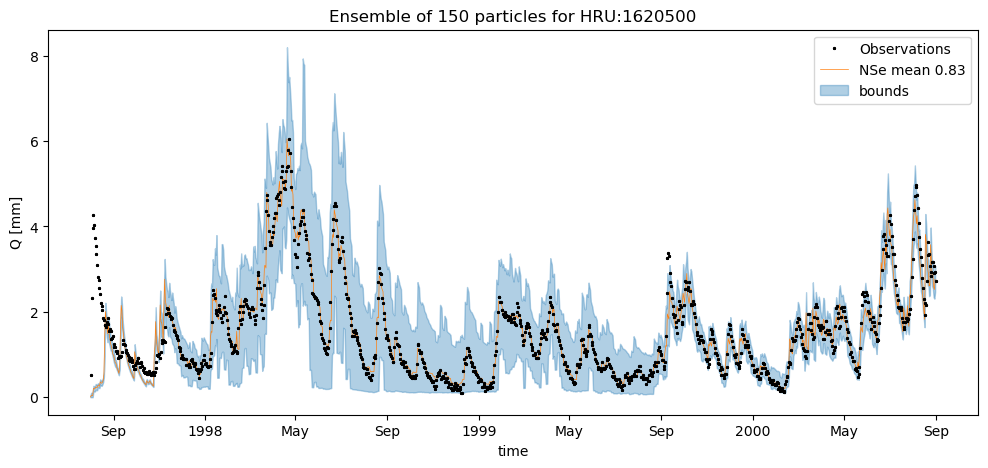

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend()
ax.set_ylabel("Q [mm]")
ax.set_title(f"Ensemble of {n_particles} particles for HRU:{HRU_id}");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

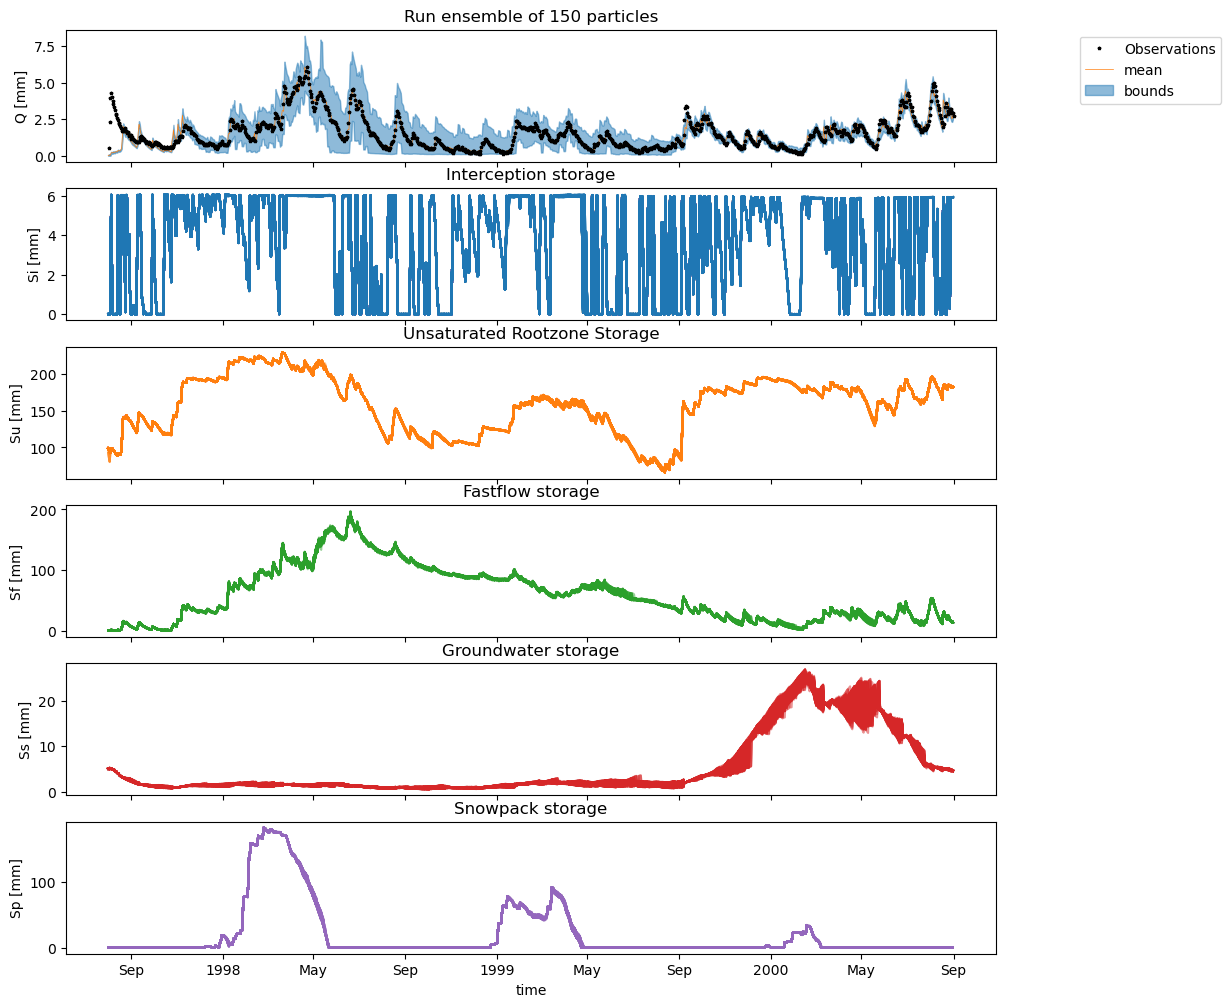

In [41]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        ds_combined[stor_names[i]].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)
        axs[i+1].set_ylabel(f'{stor_names[i]} [{units[stor_names[i]]}]')
[ax.set_xlabel(None) for ax in axs[:-1]]# remove all unncecearry xlabels
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)